In [18]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
from torch.utils.data import random_split
%matplotlib inline

In [8]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [9]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, ".")

ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}
vocab_size = len(chars)

print(ctoi)
print(vocab_size)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
27


In [20]:
train_wd, valid_wd, test_wd = random_split(words, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(420))

In [21]:
kernel_size = 3

def char_tensor(word):
    return torch.tensor([ctoi[c] for c in word])

def build_dataset(words):
    X = [char_tensor("."*kernel_size+w) for w in words]
    Y = [char_tensor(w + ".") for w in words]
    
    return X, Y

# (sample_size, seq_len)
train_x, train_y = build_dataset(train_wd)
valid_x, valid_y = build_dataset(train_wd)

In [11]:
class Transpose(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.T
    
    def string(self):
        return "Transpose"

```
kkk
...steven
   steven.
```

- input:  seq_len
- output: seq_len - kernal_size + 1

In [12]:
embed_size = 10
hidden_size = 30

# input (seq)
model = nn.Sequential(
    nn.Embedding(vocab_size, embed_size), # (seq, embed)
    Transpose(), # (embed, seq)
    nn.Conv1d(in_channels=embed_size, out_channels=hidden_size, kernel_size=kernel_size), # (hidden, seq)
    Transpose(), # (seq, hidden)
    nn.Tanh(),
    nn.Linear(hidden_size, vocab_size)
)

for p in model.parameters():
    p.requires_grad = True
    
print(sum((p.nelement() for p in model.parameters())))

2037


In [13]:
x = train_x[5]
y = train_y[5]

model(x).shape

torch.Size([10, 27])

In [14]:
len(train_x)

32033

In [25]:
@torch.no_grad()
def eval_split():    
    lossi = []
    
    for (x, y) in zip(valid_x, valid_y):
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        lossi.append(loss.item())
    
    return torch.tensor(lossi).mean()

In [15]:
import random

lossi = []
for i in range(30):
    data = list(zip(train_x, train_y))
    random.shuffle(data)
    
    for (x, y) in data:
        for p in model.parameters():
            p.grad = None
        
        logits = model(x)
        loss = F.cross_entropy(logits, y)            
        loss.backward()

        lr = 0.1 if len(lossi) < 100000 else 0.01
        for p in model.parameters():
            p.data += -lr * p.grad
            
        lossi.append(loss.item())
        if len(lossi) % 30000 == 0:
            print(lossi[-1])

2.695361852645874
2.2960426807403564
2.537336826324463
2.4040701389312744
2.084315538406372
1.8676137924194336
2.294135808944702
2.4548697471618652
2.1648457050323486
2.0965075492858887
1.6272170543670654
2.29252290725708
2.3476362228393555
2.62477445602417
1.684863805770874
2.094592571258545
1.6280806064605713
2.642763376235962
1.9823147058486938
1.81447434425354
2.2518482208251953
1.8503013849258423
2.4624338150024414
2.5528011322021484
2.4299607276916504
1.9243309497833252
2.162618637084961
2.3530821800231934
2.9504241943359375
2.313488483428955
1.7898902893066406
2.1524319648742676


In [22]:
print(f"baseline (random guess): {-torch.tensor(1/27).log():.4f}")
print(f"train loss: {torch.tensor(lossi[-5000:]).mean():.4f}")

baseline (random guess): 3.2958
train loss: 2.2234


In [26]:
eval_split()

tensor(2.2155)

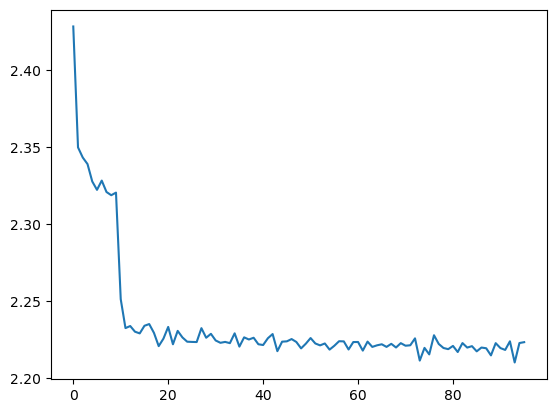

In [24]:
m = 10000
clip = len(lossi) - (len(lossi) % m)

l = torch.tensor(lossi[0:clip])
l = l.view(-1, m).mean(1)
plt.plot(l)

#### Log
- Single example stocastic gradient
  - train 2.20

In [103]:
for i in range(30):
    sample = [0] * kernel_size

    while(True):
        ctx = sample[-kernel_size:] 
        ctx = torch.tensor(ctx) # (K)
        logits = model(ctx) # (1, 27)
        prob = F.softmax(logits, 1).view(-1)
        idx = torch.multinomial(prob, 1, generator=g)
        ix = idx[0].item()
        sample.append(ix)

        if ix == 0 or len(sample) > 50:
            break

    word = "".join([itoc[idx] for idx in sample[kernel_size:-1]])
    print(word)

mari
pora
yel
naiighoseli
mem
fecta
tiese
paydahzyna
eroner
jaituriaso
crichakismeamere
aira
meveigharaannef
lian
keorteahajias
rena
hon
keik
borynn
miciawat
azhansidi
syle
kediegh
kiha
denon
etdra
avian
tatimarvelinta
ley
kelsy
